In [1]:
import jupyros as jr
import rospy
import numpy as np
from sensor_msgs import msg
import cv2
import cv_bridge
from copy import deepcopy
import ipywidgets as widgets
from IPython.display import clear_output, Image, display
import PIL.Image
from cStringIO import StringIO
import matplotlib.pyplot as plt
import dvrk
import PyKDL
import tf
from tf_conversions import posemath

In [2]:
rospy.init_node('notebook')

In [3]:
rospy.get_published_topics()

[['/dvrk/setup_joint/robot_state', 'std_msgs/String'],
 ['/dvrk/PSM1/current_state', 'std_msgs/String'],
 ['/dvrk/ECM/wrench_body_current', 'geometry_msgs/WrenchStamped'],
 ['/stereo/right/image_flipped', 'sensor_msgs/Image'],
 ['/dvrk/PSM2/position_cartesian_local_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/SUJ/ECM/position_cartesian_local_current',
  'geometry_msgs/PoseStamped'],
 ['/dvrk/SUJ/PSM2/position_cartesian_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/console/teleop/teleop_psm_selected', 'diagnostic_msgs/KeyValue'],
 ['/dvrk/PSM2/joint_velocity_ratio', 'std_msgs/Float64'],
 ['/dvrk/ECM/state_joint_desired', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_unselected', 'diagnostic_msgs/KeyValue'],
 ['/dvrk/PSM2/position_cartesian_desired', 'geometry_msgs/PoseStamped'],
 ['/dvrk/ECM/position_cartesian_local_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/PSM1/status', 'std_msgs/String'],
 ['/dvrk/console/teleop/scale', 'std_msgs/Float32'],
 ['/dvrk/tf_br

In [4]:
bridge = cv_bridge.CvBridge()
left_image = None
left_image_msg = None
left_camera_info = None

right_image = None
right_image_msg = None
right_camera_info = None

def left_image_callback(im_msg):
    global left_image, left_image_msg
    left_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    left_image_msg = im_msg
    
def right_image_callback(im_msg):
    global right_image, right_image_msg
    right_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    right_image_msg = im_msg
    
def left_camera_info_callback(camera_info_msg):
    global left_camera_info
    left_camera_info = camera_info_msg
    
def right_camera_info_callback(camera_info_msg):
    global right_camera_info
    right_camera_info = camera_info_msg
    
jr.subscribe('/stereo/left/image_flipped', msg.Image, left_image_callback)
jr.subscribe('/stereo/left/camera_info', msg.CameraInfo, left_camera_info_callback)
jr.subscribe('/stereo/right/image_flipped', msg.Image, right_image_callback)
jr.subscribe('/stereo/right/camera_info', msg.CameraInfo, right_camera_info_callback)

VkJveChjaGlsZHJlbj0oSEJveChjaGlsZHJlbj0oQnV0dG9uKGRlc2NyaXB0aW9uPXUnU3RvcCcsIHN0eWxlPUJ1dHRvblN0eWxlKCkpLCkpLCBPdXRwdXQobGF5b3V0PUxheW91dChib3JkZXLigKY=


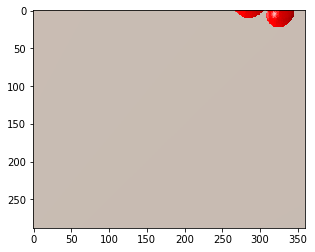

In [5]:
left_image = cv2.flip(left_image, 0)
plt.imshow(left_image)

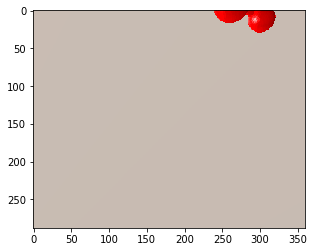

In [6]:
right_image = cv2.flip(right_image, 0)
plt.imshow(right_image)

In [7]:
print("LEFT CAM")
print(left_camera_info)
print("RIGHT_CAM")
print(right_camera_info)

LEFT CAM
header: 
  seq: 11529
  stamp: 
    secs: 1590013747
    nsecs: 496665239
  frame_id: "left_camera"
height: 288
width: 360
distortion_model: "plumb_bob"
D: [0.0, 0.0, 0.0, 0.0, 0.0]
K: [311.9603517065951, 0.0, 180.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [311.9603517065951, 0.0, 180.0, 0.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 1
binning_y: 1
roi: 
  x_offset: 0
  y_offset: 0
  height: 0
  width: 0
  do_rectify: True
RIGHT_CAM
header: 
  seq: 11529
  stamp: 
    secs: 1590013747
    nsecs: 496665239
  frame_id: "right_camera"
height: 288
width: 360
distortion_model: "plumb_bob"
D: [0.0, 0.0, 0.0, 0.0, 0.0]
K: [311.9603517065951, 0.0, 180.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [311.9603517065951, 0.0, 180.0, -1.5598017585329753, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 1
binning_y: 1
roi: 
  x_offset: 0


In [8]:
psm1 = None 
ecm = None
suj = None
debug_output = widgets.Output(layout={'border': '1px solid black'})

with debug_output:
    global psm1, ecm
    psm1 = dvrk.psm('PSM1')
    ecm = dvrk.ecm('ECM')
    suj = dvrk.suj('ECM')


In [26]:
psm1.get_current_position()

[[           1,-8.86787e-06,  7.3459e-06;
   1.1465e-05,    0.707179,   -0.707035;
  1.07503e-06,    0.707035,    0.707179]
[     1.95011,  -0.0927632,    -0.87215]]

In [27]:
ecm.get_current_position()

[[          -1,-6.27083e-06,-6.27028e-06;
  -8.8679e-06,    0.707179,    0.707035;
  5.09929e-10,    0.707035,   -0.707179]
[ 2.93028e-06,    0.580657,    0.244121]]

In [28]:
suj.get_current_position()

[[          -1, 6.27081e-06, 2.59709e-06;
 -6.27081e-06,   -0.707176,   -0.707037;
 -2.59709e-06,   -0.707037,    0.707176]
[  3.6871e-06,    0.495318,    0.329477]]

In [29]:
tf_listener = tf.TransformListener()

In [31]:
tf_listener.getFrameStrings()

['PSM2_tool_wrist_shaft_link',
 'PSM2_outer_pitch_front_link',
 'PSM2_tool_main_link',
 'PSM2_tool_wrist_caudier_link_2_left',
 'PSM1',
 'PSM2',
 'PSM2_tool_wrist_caudier_ee_link',
 'PSM2_outer_insertion_link',
 'PSM1_tool_wrist_sca_ee_link_2',
 'ecm_setup_link',
 'ecm_yaw_link',
 'PSM2_tool_wrist_caudier_link_shaft',
 'PSM1_tool_wrist_sca_ee_link_0',
 'ECM',
 'PSM1_outer_pitch_link',
 'PSM2_base',
 'PSM2_outer_pitch_link',
 'PSM1_tool_tip_link',
 'camera',
 'PSM1_tool_wrist_sca_ee_link_1',
 'PSM1_outer_pitch_front_link',
 'ecm_pitch_link',
 'PSM2_tool_wrist_caudier_link',
 'PSM1_outer_yaw_link',
 'ecm_insertion_link',
 'Jp21_ECM',
 'ecm_pitch_link_2',
 'ecm_pitch_link_3',
 'PSM1_tool_wrist_shaft_link',
 'PSM2_outer_pitch_back_link',
 'PSM1_tool_wrist_sca_link',
 'PSM2_outer_pitch_top_link',
 'PSM3_base',
 'PSM2_tool_wrist_caudier_ee_link_0',
 'PSM1_outer_insertion_link',
 'PSM2_outer_pitch_bottom_link',
 'ECM_base',
 'PSM1_outer_pitch_top_link',
 'ecm_pitch_link_1',
 'PSM1_outer_pitch

[INFO] [1590013865.692598]: Number of feature files:
[INFO] [1590013865.698731]: 1
[INFO] [1590013865.703259]: Feature ranges: 
[INFO] [1590013865.711666]: [[[  0.  37.  45.]
  [ 23. 100. 100.]]]
[INFO] [1590013865.722153]: 0
[INFO] [1590013865.729417]: Size: 31.25699921617557
[INFO] [1590013865.738460]: Height: 288 Width: 360
[INFO] [1590013865.754105]: [x: 242.0
y: 223.0]
[INFO] [1590013865.767465]: [[242. 223.]]
[INFO] [1590013865.784295]: Size: 0.0
[INFO] [1590013865.801232]: Height: 288 Width: 360
[INFO] [1590013865.816852]: [x: 232.0
y: 220.0]
[INFO] [1590013865.820062]: [[232. 220.]]
[INFO] [1590013865.828627]: Size: 0.0
type: 
  data: "centroids"
center: 
  x: 242
  y: 223
zoom: 
  data: 1.0
yaw_angle: 
  data: 0.0
points: 
  - 
    x: 242.0
    y: 223.0


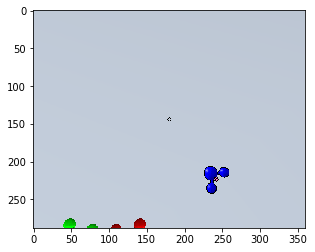

In [32]:
import image_geometry
import vision_pipeline
BALL_FEAT_PATH = '../autonomous_surgical_camera/auto_cam/config/features/red_ball.csv'
cv2.imwrite('left.png', left_image)
fp = vision_pipeline.feature_processor([BALL_FEAT_PATH], 'left.png')
left_feats, left_frame = fp.Centroids(left_image_msg)
right_feats, right_frame = fp.Centroids(right_image_msg)
print(left_feats)
plt.imshow(left_frame)

type: 
  data: "centroids"
center: 
  x: 232
  y: 220
zoom: 
  data: 1.0
yaw_angle: 
  data: 0.0
points: 
  - 
    x: 232.0
    y: 220.0


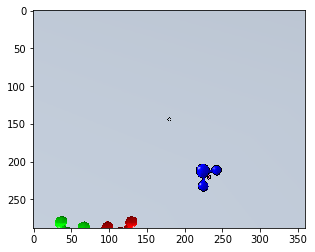

In [33]:
print(right_feats)
plt.imshow(right_frame)

[(242.0, 223.0)]
[(232.0, 220.0)]


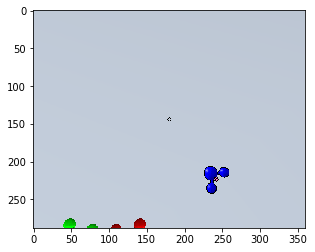

In [34]:
left_cam = image_geometry.PinholeCameraModel()
left_cam.fromCameraInfo(left_camera_info)
right_cam = image_geometry.PinholeCameraModel()
right_cam.fromCameraInfo(right_camera_info)
left_frame_rectified = deepcopy(left_frame)

def rectify(cam, ros_pt):
    return tuple(cam.rectifyPoint((ros_pt.x, ros_pt.y)))

def invert_rectify(cam, ros_pt, frame_dims):
    return tuple(cam.rectifyPoint((frame_dims[0] - ros_pt.x, frame_dims[1] - ros_pt.y)))

left_feat_pts = [rectify(left_cam, pt) for pt in left_feats.points]
right_feat_pts = [rectify(right_cam, pt) for pt in right_feats.points]
print(left_feat_pts)
print(right_feat_pts)
left_cam.rectifyImage(left_frame, left_frame_rectified)
plt.imshow(left_frame)

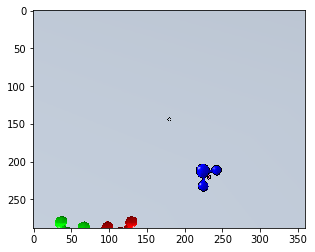

[ERROR] [1590013988.280639]: bad callback: <bound method psm.__state_joint_current_cb of <dvrk.psm.psm object at 0x7fa60ccd18d0>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effort_joint_current.resize(len(data.effort))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

[ERROR] [1590014025.422330]: bad callback: <bound method psm.__state_joint_current_cb of <dvrk.psm.psm object at 0x7fa60ccd18d0>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effort_j

In [35]:
right_frame_rectified = deepcopy(right_frame)
left_cam.rectifyImage(right_frame, right_frame_rectified)
plt.imshow(right_frame_rectified)

In [150]:
from visualization_msgs.msg import Marker
marker_pub = rospy.Publisher('/visualization_marker', Marker, queue_size=10000)

In [151]:
def publish_marker(point, frame, marker_id):
    global marker
    marker = Marker()
    marker.ns = 'malding'
    marker.header.frame_id = frame
    marker.header.stamp = rospy.Time.now()
    marker.type = Marker.SPHERE
    marker.action = Marker.ADD
    marker.id = marker_id
    marker.pose.position.x = point.x()
    marker.pose.position.y = point.y()
    marker.pose.position.z = point.z()
    marker.pose.orientation.x = 0.0
    marker.pose.orientation.y = 0.0
    marker.pose.orientation.z = 0.0
    marker.pose.orientation.w = 1.0
    marker.scale.x = 1.0
    marker.scale.y = 1.0
    marker.scale.z = 1.0
    marker.color.a = 1.0
    marker.color.r = 1.0
    marker.color.g = 0.0
    marker.color.b = 0.0
    marker.lifetime = rospy.Time.from_sec(10000)
    marker_pub.publish(marker)

In [152]:
stereocam = image_geometry.StereoCameraModel()
stereocam.fromCameraInfo(left_camera_info, right_camera_info)
disparity = abs(left_feat_pts[0][0] - right_feat_pts[0][0])
print(disparity)
ball_pos_cam = stereocam.projectPixelTo3d(left_feat_pts[0], disparity)
print(ball_pos_cam)

10.0
(0.031, 0.0395, 0.15598017585329754)


In [153]:
def tfl_to_pykdl_frame(tfl_frame):
    pos, rot_quat = tfl_frame
    pos2 = PyKDL.Vector(*pos)
    rot = PyKDL.Rotation.Quaternion(*rot_quat)
    return PyKDL.Frame(rot, pos2)

In [160]:
ball_pos_cam = PyKDL.Vector(*ball_pos_cam)
print(ball_pos_cam)
publish_marker(ball_pos_cam, 'ecm_yaw_link', 50)

[       0.031,      0.0395,     0.15598]


[WARN] [1590037969.074491]: Inbound TCP/IP connection failed: connection from sender terminated before handshake header received. 0 bytes were received. Please check sender for additional details.


In [149]:
tf_cam_to_pitch_link = tf_listener.lookupTransform('ecm_pitch_link', 'camera', rospy.Time())
tf_cam_to_pitch_link = tfl_to_pykdl_frame(tf_cam_to_pitch_link)
tf_pitch_link_to_world = tf_listener.lookupTransform('simworld', 'Jp21_ECM', rospy.Time())
tf_pitch_link_to_world = tfl_to_pykdl_frame(tf_pitch_link_to_world)
tf_cam_to_world = tf_pitch_link_to_world * tf_cam_to_pitch_link
tf_cam_to_world

[[   -0.859879,   0.0362228,    0.509212;
    0.0291713,    0.999336,  -0.0218278;
    -0.509665, -0.00391484,   -0.860364]
[    -1.20754, -0.00607374,    0.905844]]

In [58]:
# there's a hardcoded rotation between J1_PSM1 in sim and PSM1_psm_main
j1_to_main_rot = PyKDL.Rotation(
    PyKDL.Vector(-1,  0,  0),
    PyKDL.Vector( 0,  0, -1),
    PyKDL.Vector( 0, -1,  0)
)
j1_to_main_trans = PyKDL.Vector(0, 0, 0)
j1_to_main_frame = PyKDL.Frame(j1_to_main_rot, j1_to_main_trans)

tf_world_to_psm1_j1 = tf_listener.lookupTransform('J1_PSM1', 'simworld', rospy.Time())
tf_world_to_psm1_j1 = tfl_to_pykdl_frame(tf_world_to_psm1_j1)
tf_world_to_psm1_main = j1_to_main_frame * tf_world_to_psm1_j1
tf_world_to_psm1_main

[[    0.341784,    0.939779,-9.47923e-06;
    -0.939779,    0.341784, 0.000346971;
  0.000329316,-0.000109681,           1]
[    0.655042,    -1.39907,   -0.798299]]

In [59]:
tf_camera_to_psm1 = tf_world_to_psm1_main * tf_cam_to_world
ball_pos_psm1 = tf_camera_to_psm1 * ball_pos_cam
ball_pos_psm1

[    0.289882,   -0.304366,  -0.0429918]

[ERROR] [1590018881.055518]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7fa60cd23450>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 285, in __state_joint_current_cb
    self.__velocity_joint_current.resize(len(data.velocity))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

[ERROR] [1590018942.603623]: bad callback: <bound method psm.__state_joint_current_cb of <dvrk.psm.psm object at 0x7fa60ccd18d0>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effo

[ERROR] [1590019714.204705]: bad callback: <bound method psm.__state_joint_current_cb of <dvrk.psm.psm object at 0x7fa60ccd18d0>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effort_joint_current.resize(len(data.effort))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

[ERROR] [1590019724.754704]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7fa60cd23450>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effort_j

[ERROR] [1590020549.030649]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7fa60cd23450>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effort_joint_current.resize(len(data.effort))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

[ERROR] [1590020718.372732]: bad callback: <bound method psm.__state_joint_current_cb of <dvrk.psm.psm object at 0x7fa60ccd18d0>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effort_j

[ERROR] [1590022405.297241]: bad callback: <bound method psm.__state_joint_current_cb of <dvrk.psm.psm object at 0x7fa60ccd18d0>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effort_joint_current.resize(len(data.effort))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

[ERROR] [1590022407.331832]: bad callback: <bound method psm.__state_joint_current_cb of <dvrk.psm.psm object at 0x7fa60ccd18d0>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effort_j

[ERROR] [1590023857.574913]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7fa60cd23450>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 285, in __state_joint_current_cb
    self.__velocity_joint_current.resize(len(data.velocity))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

[ERROR] [1590023904.155402]: bad callback: <bound method psm.__state_joint_current_cb of <dvrk.psm.psm object at 0x7fa60ccd18d0>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effo

[ERROR] [1590025490.905142]: bad callback: <bound method psm.__state_joint_current_cb of <dvrk.psm.psm object at 0x7fa60ccd18d0>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effort_joint_current.resize(len(data.effort))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

[ERROR] [1590025545.361271]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7fa60cd23450>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effort_j

[ERROR] [1590026714.385003]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7fa60cd23450>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effort_joint_current.resize(len(data.effort))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

[ERROR] [1590026740.190510]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7fa60cd23450>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 285, in __state_joint_current_cb
    self.__velocity

[ERROR] [1590027659.987376]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7fa60cd23450>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 285, in __state_joint_current_cb
    self.__velocity_joint_current.resize(len(data.velocity))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

[ERROR] [1590027684.454063]: bad callback: <bound method psm.__state_joint_current_cb of <dvrk.psm.psm object at 0x7fa60ccd18d0>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effo

[ERROR] [1590029609.289172]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7fa60cd23450>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effort_joint_current.resize(len(data.effort))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

[ERROR] [1590029635.008362]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7fa60cd23450>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 285, in __state_joint_current_cb
    self.__velocity

[ERROR] [1590030712.633843]: bad callback: <bound method psm.__state_joint_current_cb of <dvrk.psm.psm object at 0x7fa60ccd18d0>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effort_joint_current.resize(len(data.effort))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

[ERROR] [1590030888.876301]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7fa60cd23450>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 285, in __state_joint_current_cb
    self.__velocity

[ERROR] [1590032616.745245]: bad callback: <bound method psm.__state_joint_current_cb of <dvrk.psm.psm object at 0x7fa60ccd18d0>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effort_joint_current.resize(len(data.effort))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

[ERROR] [1590032617.636010]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7fa60cd23450>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effort_j

[ERROR] [1590034350.461404]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7fa60cd23450>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 285, in __state_joint_current_cb
    self.__velocity_joint_current.resize(len(data.velocity))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

[ERROR] [1590034414.151762]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7fa60cd23450>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effo